<a href="https://colab.research.google.com/github/HerbertAnchovy/notebooks/blob/master/Week_4_project_J_Phipps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<a id="Top"></a>
<img style="float: left;" src="https://msds.open.ac.uk/includes/oulogo_hor_75x55.gif">&nbsp;&nbsp;&nbsp;
</div>
<br/>
<br/>

## Project 4: Exploring the UK's hop-based product imports and exports

#### produced by [Jez Phipps](https://www.futurelearn.com/profiles/3841612) on 7<sup>th</sup> November 2016.

This is my project notebook for Week 4 of The Open University's [_Learn to Code for Data Analysis_](http://futurelearn.com/courses/learn-to-code) course.

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the UK's imports and exports of three hop-based products (see commodity descriptors below) in 2014:

- How much does the UK export and import and is the balance positive (more exports than imports)? 
- Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?
- Which are the regular customers, i.e. which countries buy the products from the UK every month?
- Which countries does the UK both import from and export to?

In [0]:
from IPython.display import display, HTML
HTML('''Note: <p style="display:inline;color:darkred;">Option to toggle code visibility on/off is at <a href="#Bottom">bottom</a> of page.</p>''')

In [0]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: All of 2014
- Reporter: United Kingdom
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: **1210** (Hop cones, fresh or dried, lupulin), **121010** (Hop cones, not ground, powdered or pelleted), **130213** (Hop extract)

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the *Download CSV* button and the download file renamed appropriately.

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

- `max=500` is increased to `max=5000` to make sure all data is loaded,
- `&fmt=csv` is added at the end to obtain the data in CSV format.

In [0]:
LOCATION = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=2014&r=826&p=all&rg=1%2C2&cc=1210%2C121010%2C130213&fmt=csv'

On reading in the data, the commodity code has to be read as a string to ensure we do not lose the leading zeroes.

In [0]:
hops = read_csv(LOCATION, dtype={'Commodity Code':str})
hops.tail()

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,Reporter ISO,Partner Code,Partner,Partner ISO,2nd Partner Code,2nd Partner,2nd Partner ISO,Customs Proc. Code,Customs,Mode of Transport Code,Mode of Transport,Commodity Code,Commodity,Qty Unit Code,Qty Unit,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
1042,HS,2014,201411,November 2014,6,1,1,Imports,826,United Kingdom,NaN,56,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130213,Vegetable saps and extracts; of hops,NaN,NaN,NaN,NaN,NaN,NaN,3019,NaN,245410,NaN,NaN,0
1043,HS,2014,201411,November 2014,6,1,1,Imports,826,United Kingdom,NaN,156,China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130213,Vegetable saps and extracts; of hops,NaN,NaN,NaN,NaN,NaN,NaN,100,NaN,6683,NaN,NaN,0
1044,HS,2014,201411,November 2014,6,1,1,Imports,826,United Kingdom,NaN,826,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130213,Vegetable saps and extracts; of hops,NaN,NaN,NaN,NaN,NaN,NaN,213,NaN,3752,NaN,NaN,0
1045,HS,2014,201411,November 2014,6,1,1,Imports,826,United Kingdom,NaN,842,United States of America,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130213,Vegetable saps and extracts; of hops,NaN,NaN,NaN,NaN,NaN,NaN,88730,NaN,2427012,NaN,NaN,0
1046,HS,2014,201411,November 2014,6,1,1,Imports,826,United Kingdom,NaN,724,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130213,Vegetable saps and extracts; of hops,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,1989,NaN,NaN,0


Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [0]:
def hopsType(code):
    if code == '1210':   # Hop cones, fresh or dried, lupulin
        return 'cones_1'
    if code == '121010': # Hop cones, not ground, powdered or pelleted
        return 'cones_2'
    if code == '130213': # Hop extract
        return 'extract' 
    return 'unknown'

COMMODITY = 'Hop-based products'
hops[COMMODITY] = hops['Commodity Code'].apply(hopsType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
hops = hops[headings]
hops.head()

,Period,Partner,Trade Flow,Hop-based products,Trade Value (US$)
0,201403,World,Imports,cones_2,1499720
1,201403,Germany,Imports,cones_2,10883
2,201403,France,Imports,cones_2,1001153
3,201403,Poland,Imports,cones_2,16060
4,201403,Slovenia,Imports,cones_2,75782


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [0]:
hops = hops[hops[PARTNER] != 'World']
hops.head()

,Period,Partner,Trade Flow,Hop-based products,Trade Value (US$)
1,201403,Germany,Imports,cones_2,10883
2,201403,France,Imports,cones_2,1001153
3,201403,Poland,Imports,cones_2,16060
4,201403,Slovenia,Imports,cones_2,75782
5,201403,United States of America,Imports,cones_2,395841


In [0]:
print("\nNote: The UK trade partners consist of " + str(len(hops['Partner'].unique())) + " different countries.")


Note: The UK trade partners consist of 74 different countries.


## Total trade flow

To answer the first question, **'How much does the UK export and import and is the balance positive (more exports than imports)?'**,
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [0]:
grouped = hops.groupby([FLOW])
hops_flow_totals = grouped[VALUE].aggregate(sum)
hops_flow_totals

Trade Flow
Exports    59473468
Imports    91270334
Name: Trade Value (US$), dtype: int64

In [0]:
def roundToMillions (value):
    return round((value / 1000000),1)

# Let's get the trade surplus:
surplus = hops_flow_totals['Imports'] - hops_flow_totals['Exports']
print("This shows a trade surplus of about " + str(roundToMillions(surplus)) + " million US$.")

This shows a trade surplus of about 31.8 million US$.


## Main trade partners

To address the second question, **'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?'**, the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [0]:
imports = hops[hops[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

The UK imports from 19 countries.
The 5 biggest exporters to the UK are:


Partner
United States of America    39915608
Germany                     17281076
France                       9413829
Belgium                      8874391
Slovenia                     6092866
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

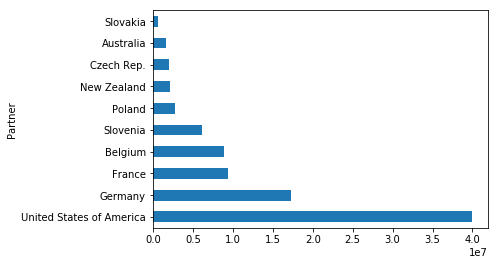

In [0]:
totalImports.head(10).plot(kind='barh')

In [0]:
exports = hops[hops[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
totalExports = grouped[VALUE].aggregate(sum).sort_values(ascending=False).head()
totalExports.head()

The UK exports to 72 countries.
The 5 biggest importers from the UK are:


Partner
United States of America    9431078
Germany                     9158415
Nigeria                     6862093
Belgium                     5664460
Brazil                      4700374
Name: Trade Value (US$), dtype: int64

In [0]:
i = totalImports.head(1)[0]
i = str(roundToMillions(i))
e = totalExports.head(1)[0]
e = str(roundToMillions(e))

print("The above clearly shows that the U.S. is our largest partner.")
print("However, our imports from the U.S. are about " + i + " million US$ and our exports are about " + e + " million US$.")
balance_of_trade = (totalExports.head(1)[0]) - (totalImports.head(1)[0]) # Country's imports exceed its exports.
print("Consequently, the balance of trade is about " + str(roundToMillions(balance_of_trade)) + " million US$.")

The above clearly shows that the U.S. is our largest partner.
However, our imports from the U.S. are about 39.9 million US$ and our exports are about 9.4 million US$.
Consequently, the balance of trade is about -30.5 million US$.


## Regular importers

Given that there are three commodities, the third question, **'Which are the regular customers, i.e. which countries buy hop-based exports from the UK every month?'**, is meant in the sense that a regular customer buys (imports) _all three commodities every month._ This means that if the exports dataframe is grouped by country, each group has exactly 36 rows (three commodities bought each of the 12 months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [0]:
def buysEveryMonth(group):
    return len(group) == 36

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular = regular[(regular[MONTH] == 201401) & (regular[COMMODITY] == 'extract')]
regular

,Period,Partner,Trade Flow,Hop-based products,Trade Value (US$)
96,201401,Ireland,Exports,extract,336060
101,201401,France,Exports,extract,63928


In [0]:
pc=((regular[VALUE].sum() / exports[VALUE].sum())*100)
regulars = len(regular)
print("Approximately " + str(round(pc,2)) + "% of the total UK exports are due to the", regulars ,"regular customer(s) identified above.")

Approximately 0.67% of the total UK exports are due to the 2 regular customer(s) identified above.


## Bi-directional trade

To address the fourth question, 
**'Which countries does the UK both import from and export to?**', a pivot table is used to list the total export and import value for each country. 

In [0]:
countries = pivot_table(hops, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Argentina,359284.0,NaN
Australia,1370282.0,1673828.0
Austria,1335.0,NaN
Belarus,110361.0,NaN
Belgium,5664460.0,8874391.0


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [0]:
print("\nThe UK has bi-directional trade flow with the following " + str(len(countries.dropna())) + " countries.\n")
display(countries.dropna())


The UK has bi-directional trade flow with the following 17 countries.



Trade Flow,Exports,Imports
Partner,,
Australia,1370282.0,1673828.0
Belgium,5664460.0,8874391.0
Canada,601190.0,3024.0
China,430125.0,56097.0
Czech Rep.,254642.0,1998597.0
Denmark,593679.0,122416.0
France,1221984.0,9413829.0
Germany,9158415.0,17281076.0
India,121934.0,38215.0


## Conclusions

The UK hops-based product trade in 2014 was analysed in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK had a **trade surplus of over 32 million US dollars with 74 different parther countries**.

The **U.S. is the main partner**, but the UK imported almost over three times the value of hop-based goods from the U.S. than it exported to them (i.e. a substantial trade deficit of about 31 million US dollars). 

The UK **exported to 72 countries** during the period, but only **imported from 19 countries**. Germany and France are the next two main customers for both hop imports into, and exports out of, the UK.

Interestingly, the UK is not very heavily dependent on its regular customers, since there are only two countries out of 74 that buy all three types of hops-based commodities every month (France and Ireland). This accounts for less than 1% of exports. However, the UK does rely significantly on France for imported goods. 

The UK has bi-directional trade (i.e. both exports and imports) with 17 countries, although for some (i.e. Peru) the trade value is suprisingly low.

In [0]:
HTML('''<script>  
function toggler() { 
$('div.input').toggle(); 
location.href="#Bottom";
} 
</script>
<p style="display:inline;"><center>Click <a href="javascript:toggler();">here</a> to toggle code visibility on/off</center></p>
<script>
$('div.input').hide();
location.href="#Top";</script></div>''')

<div><a id="Bottom"></a>&copy; 2016 Phipps E&amp;OE.</div>